# 区分并发(Concurrency)和并行(Parallelism)

在Python中，并发并不是指同一时刻有多个操作(thread,task)同时进行。相反，某个特定的时刻，只允许有一个操作发生，只不过线程/任务之间会相互切换，直到完成。像这样：


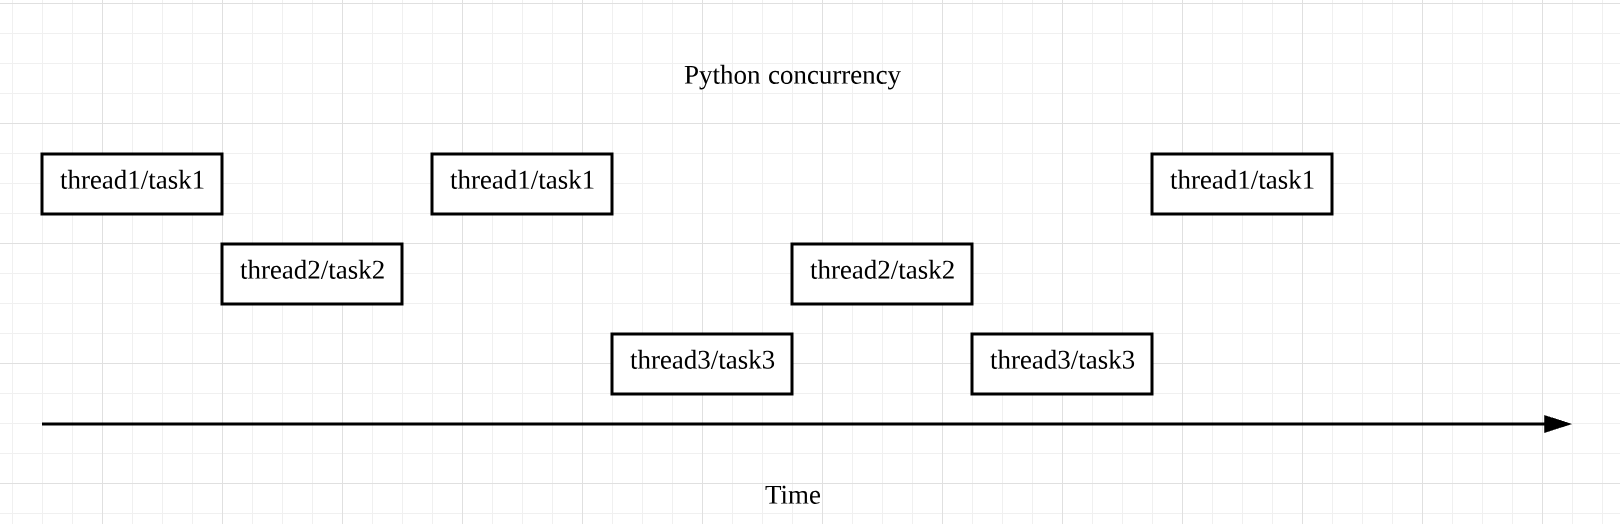

图中出现了thread和task两种切换顺序的不同方式，分别对应Python中并发的两种形式----`threading`和`asyncio`。


**对于 threading，操作系统知道每个线程的所有信息，因此它会做主在适当的时候做线程切换。**很显然，这样的好处是代码容易书写，因为程序员不需要做任何切换操作的处理；但是切换线程的操作，也有可能出现在一个语句执行的过程中（比如 x += 1），这样就容易出现 race condition 的情况。

而对于 asyncio，主程序想要切换任务时，必须得到此任务可以被切换的通知，这样一来也就可以避免刚刚提到的 race condition 的情况。

至于所谓的**并行，指的才是同一时刻、同时发生**。Python 中的 multi-processing 便是这个意思，对于 multi-processing，你可以简单地这么理解：比如你的电脑是 6 核处理器，那么在运行程序时，就可以强制 Python 开 6 个进程，同时执行，以加快运行速度，它的原理示意图如下：

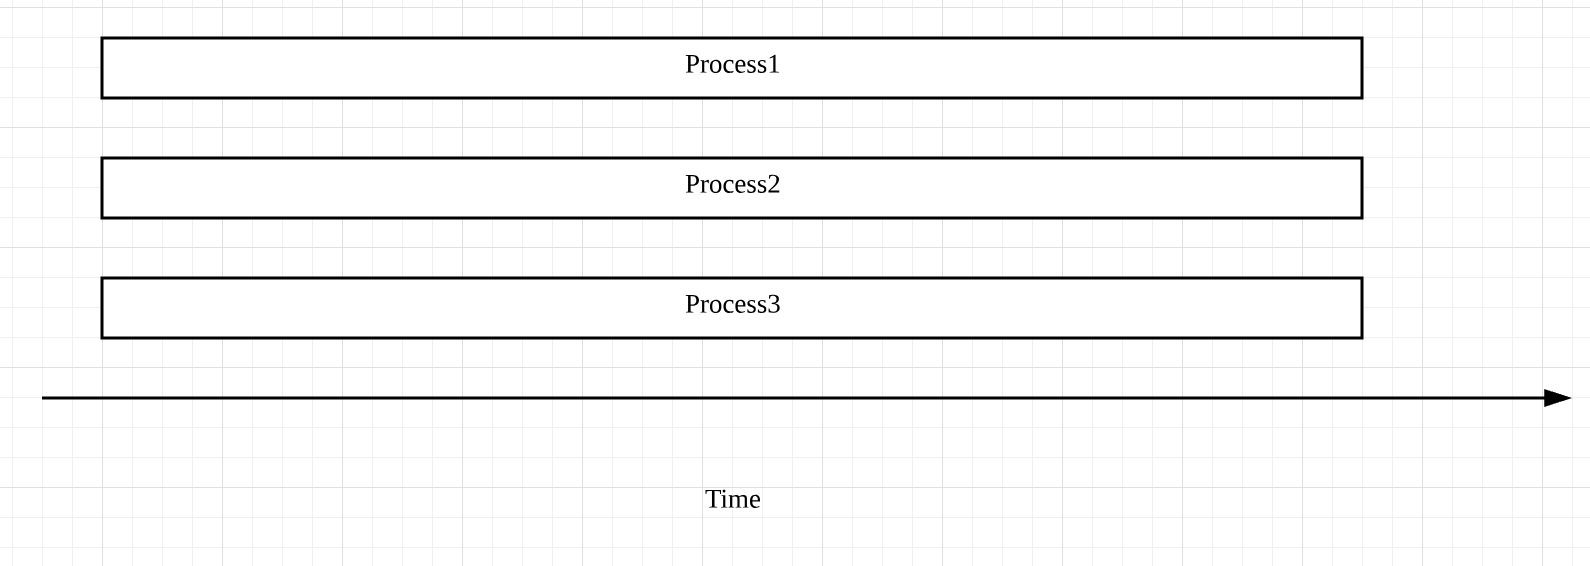


对比来看：

1. **并发通常应用于I/O操作频繁的场景**，比如你要从网站上下载多个文件，I/O操作的时间可能会比CPU运行处理的时间长得多
2. **并行则更多应用于CPU heavy的场景**，比如MapReduce中的并行计算，为了加快运行速度，一般会用更多台机器、多个处理器来完成。

# 并发编程之Futures

## 单线程与多线程性能比较
从代码的角度来理解并发编程中的 Futures，并进一步来比较其与单线程的性能区别。


假设我们有一个任务，是下载一些网站的内容并打印。如果用单线程的方式，它的代码实现如下所示（为了简化代码，突出主题，此处我忽略了异常处理）：
```python
import requests
import time

def download_one(url):
    resp = requests.get(url)
    print('Read {} from {}'.format(len(resp.content), url))
    
def download_all(sites):
    for site in sites:
        download_one(site)

def main():
    sites = [
        'https://en.wikipedia.org/wiki/Portal:Arts',
        'https://en.wikipedia.org/wiki/Portal:History',
        'https://en.wikipedia.org/wiki/Portal:Society',
        'https://en.wikipedia.org/wiki/Portal:Biography',
        'https://en.wikipedia.org/wiki/Portal:Mathematics',
        'https://en.wikipedia.org/wiki/Portal:Technology',
        'https://en.wikipedia.org/wiki/Portal:Geography',
        'https://en.wikipedia.org/wiki/Portal:Science',
        'https://en.wikipedia.org/wiki/Computer_science',
        'https://en.wikipedia.org/wiki/Python_(programming_language)',
        'https://en.wikipedia.org/wiki/Java_(programming_language)',
        'https://en.wikipedia.org/wiki/PHP',
        'https://en.wikipedia.org/wiki/Node.js',
        'https://en.wikipedia.org/wiki/The_C_Programming_Language',
        'https://en.wikipedia.org/wiki/Go_(programming_language)'
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))
    
if __name__ == '__main__':
    main()

# 输出
Read 129886 from https://en.wikipedia.org/wiki/Portal:Arts
Read 184343 from https://en.wikipedia.org/wiki/Portal:History
Read 224118 from https://en.wikipedia.org/wiki/Portal:Society
Read 107637 from https://en.wikipedia.org/wiki/Portal:Biography
Read 151021 from https://en.wikipedia.org/wiki/Portal:Mathematics
Read 157811 from https://en.wikipedia.org/wiki/Portal:Technology
Read 167923 from https://en.wikipedia.org/wiki/Portal:Geography
Read 93347 from https://en.wikipedia.org/wiki/Portal:Science
Read 321352 from https://en.wikipedia.org/wiki/Computer_science
Read 391905 from https://en.wikipedia.org/wiki/Python_(programming_language)
Read 321417 from https://en.wikipedia.org/wiki/Java_(programming_language)
Read 468461 from https://en.wikipedia.org/wiki/PHP
Read 180298 from https://en.wikipedia.org/wiki/Node.js
Read 56765 from https://en.wikipedia.org/wiki/The_C_Programming_Language
Read 324039 from https://en.wikipedia.org/wiki/Go_(programming_language)
Download 15 sites in 2.464231112999869 seconds
```

这种方式应该是最直接也最简单的： 
1. 先是遍历存储网站的列表； 
2. 然后对当前网站执行下载操作； 
3. 等到当前操作完成后，再对下一个网站进行同样的操作，一直到结束。 

我们可以看到总共耗时约 2.4s。单线程的优点是简单明了，但是明显效率低下，因为上述程序的绝大多数时间，都浪费在了 I/O 等待上。程序每次对一个网站执行下载操作，都必须等到前一个网站下载完成后才能开始。如果放在实际生产环境中，我们需要下载的网站数量至少是以万为单位的，不难想象，这种方案根本行不通。

接着我们再来看，多线程版本的代码实现：
```python
import concurrent.futures
import requests
import threading
import time

def download_one(url):
    resp = requests.get(url)
    print('Read {} from {}'.format(len(resp.content), url))


def download_all(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_one, sites)

def main():
    sites = [
        'https://en.wikipedia.org/wiki/Portal:Arts',
        'https://en.wikipedia.org/wiki/Portal:History',
        'https://en.wikipedia.org/wiki/Portal:Society',
        'https://en.wikipedia.org/wiki/Portal:Biography',
        'https://en.wikipedia.org/wiki/Portal:Mathematics',
        'https://en.wikipedia.org/wiki/Portal:Technology',
        'https://en.wikipedia.org/wiki/Portal:Geography',
        'https://en.wikipedia.org/wiki/Portal:Science',
        'https://en.wikipedia.org/wiki/Computer_science',
        'https://en.wikipedia.org/wiki/Python_(programming_language)',
        'https://en.wikipedia.org/wiki/Java_(programming_language)',
        'https://en.wikipedia.org/wiki/PHP',
        'https://en.wikipedia.org/wiki/Node.js',
        'https://en.wikipedia.org/wiki/The_C_Programming_Language',
        'https://en.wikipedia.org/wiki/Go_(programming_language)'
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))

if __name__ == '__main__':
    main()

## 输出
Read 151021 from https://en.wikipedia.org/wiki/Portal:Mathematics
Read 129886 from https://en.wikipedia.org/wiki/Portal:Arts
Read 107637 from https://en.wikipedia.org/wiki/Portal:Biography
Read 224118 from https://en.wikipedia.org/wiki/Portal:Society
Read 184343 from https://en.wikipedia.org/wiki/Portal:History
Read 167923 from https://en.wikipedia.org/wiki/Portal:Geography
Read 157811 from https://en.wikipedia.org/wiki/Portal:Technology
Read 91533 from https://en.wikipedia.org/wiki/Portal:Science
Read 321352 from https://en.wikipedia.org/wiki/Computer_science
Read 391905 from https://en.wikipedia.org/wiki/Python_(programming_language)
Read 180298 from https://en.wikipedia.org/wiki/Node.js
Read 56765 from https://en.wikipedia.org/wiki/The_C_Programming_Language
Read 468461 from https://en.wikipedia.org/wiki/PHP
Read 321417 from https://en.wikipedia.org/wiki/Java_(programming_language)
Read 324039 from https://en.wikipedia.org/wiki/Go_(programming_language)
Download 15 sites in 0.19936635800002023 seconds
```

总耗时是 0.2s 左右，效率一下子提升了 10 倍多。

我们具体来看这段代码，它是多线程版本和单线程版的主要区别所在：
```python
   with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_one, sites)
```

这里我们创建了一个线程池，总共有 5 个线程可以分配使用。`executer.map()` 与前面所讲的 Python 内置的 `map()` 函数类似，表示对 sites 中的每一个元素，并发地调用函数 `download_one()`。

在 download_one() 函数中，我们使用的 requests.get() 方法是线程安全的（thread-safe），因此在多线程的环境下，它也可以安全使用，并不会出现 race condition 的情况。

另外，虽然线程的数量可以自己定义，但是线程数并不是越多越好，因为线程的创建、维护和删除也会有一定的开销。所以如果你设置的很大，反而可能会导致速度变慢。我们往往需要根据实际的需求做一些测试，来寻找最优的线程数量。




当然，我们也可以用并行的方式去提高程序运行效率。你只需要在 download_all() 函数中，做出下面的变化即可：

```python
with futures.ThreadPoolExecutor(workers) as executor
=>
with futures.ProcessPoolExecutor() as executor: 
```
在需要修改的这部分代码中，函数 ProcessPoolExecutor() 表示创建进程池，使用多个进程并行的执行程序。不过，这里我们通常省略参数 workers，因为系统会自动返回 CPU 的数量作为可以调用的进程数。

并行的方式一般用在 CPU heavy 的场景中，因为对于 I/O heavy 的操作，多数时间都会用于等待，相比于多线程，使用多进程并不会提升效率。反而很多时候，因为 CPU 数量的限制，会导致其执行效率不如多线程版本。

## 到底什么是 Futures

Python 中的 Futures 模块，位于 `concurrent.futures` 和 `asyncio` 中，它们都表示带有延迟的操作。Futures 会将处于等待状态的操作包裹起来放到队列中，这些操作的状态随时可以查询，当然，它们的结果或是异常，也能够在操作完成后被获取。

通常来说，作为用户，我们不用考虑如何去创建 Futures，这些 Futures 底层都会帮我们处理好。我们要做的，实际上是去 schedule 这些 Futures 的执行。

比如，Futures 中的 Executor 类，当我们**执行 executor.submit(func) 时，它便会安排里面的 func() 函数执行，并返回创建好的 future 实例，以便你之后查询调用**。

一些比较常用的方法：

1. Futures 中的方法 `done()`，表示**相对应的操作是否完成**——True 表示完成，False 表示没有完成。不过，要注意，`done()` 是 non-blocking 的，会立即返回结果。
2. 相对应的 `add_done_callback(fn)`，则**表示 Futures 完成后，相对应的参数函数 fn，会被通知并执行调用**。
3. Futures 中还有一个重要的函数 `result()`，它表示**当 future 完成后，返回其对应的结果或异常**。
4. 而 `as_completed(fs)`，则是**针对给定的 future 迭代器 fs，在其完成后，返回完成后的迭代器**。


所以，上述例子也可以写成下面的形式：
```python

import concurrent.futures
import requests
import time

def download_one(url):
    resp = requests.get(url)
    print('Read {} from {}'.format(len(resp.content), url))

def download_all(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        to_do = []
        for site in sites:
            future = executor.submit(download_one, site)
            to_do.append(future)
            
        for future in concurrent.futures.as_completed(to_do):
            future.result()
def main():
    sites = [
        'https://en.wikipedia.org/wiki/Portal:Arts',
        'https://en.wikipedia.org/wiki/Portal:History',
        'https://en.wikipedia.org/wiki/Portal:Society',
        'https://en.wikipedia.org/wiki/Portal:Biography',
        'https://en.wikipedia.org/wiki/Portal:Mathematics',
        'https://en.wikipedia.org/wiki/Portal:Technology',
        'https://en.wikipedia.org/wiki/Portal:Geography',
        'https://en.wikipedia.org/wiki/Portal:Science',
        'https://en.wikipedia.org/wiki/Computer_science',
        'https://en.wikipedia.org/wiki/Python_(programming_language)',
        'https://en.wikipedia.org/wiki/Java_(programming_language)',
        'https://en.wikipedia.org/wiki/PHP',
        'https://en.wikipedia.org/wiki/Node.js',
        'https://en.wikipedia.org/wiki/The_C_Programming_Language',
        'https://en.wikipedia.org/wiki/Go_(programming_language)'
    ]
    start_time = time.perf_counter()
    download_all(sites)
    end_time = time.perf_counter()
    print('Download {} sites in {} seconds'.format(len(sites), end_time - start_time))

if __name__ == '__main__':
    main()

# 输出
Read 129886 from https://en.wikipedia.org/wiki/Portal:Arts
Read 107634 from https://en.wikipedia.org/wiki/Portal:Biography
Read 224118 from https://en.wikipedia.org/wiki/Portal:Society
Read 158984 from https://en.wikipedia.org/wiki/Portal:Mathematics
Read 184343 from https://en.wikipedia.org/wiki/Portal:History
Read 157949 from https://en.wikipedia.org/wiki/Portal:Technology
Read 167923 from https://en.wikipedia.org/wiki/Portal:Geography
Read 94228 from https://en.wikipedia.org/wiki/Portal:Science
Read 391905 from https://en.wikipedia.org/wiki/Python_(programming_language)
Read 321352 from https://en.wikipedia.org/wiki/Computer_science
Read 180298 from https://en.wikipedia.org/wiki/Node.js
Read 321417 from https://en.wikipedia.org/wiki/Java_(programming_language)
Read 468421 from https://en.wikipedia.org/wiki/PHP
Read 56765 from https://en.wikipedia.org/wiki/The_C_Programming_Language
Read 324039 from https://en.wikipedia.org/wiki/Go_(programming_language)
Download 15 sites in 0.21698231499976828 seconds
```
我们首先调用 executor.submit()，将下载每一个网站的内容都放进 future 队列 to_do，等待执行。然后是 as_completed() 函数，在 future 完成后，便输出结果。

不过，这里要注意，future 列表中每个 future 完成的顺序，和它在列表中的顺序并不一定完全一致。到底哪个先完成、哪个后完成，取决于系统的调度和每个 future 的执行时间。

## 为什么多线程每次只能有一个线程执行？

同一时刻，Python 主程序只允许有一个线程执行，所以 Python 的并发，是通过多线程的切换完成的。

事实上，Python 的解释器并不是线程安全的，为了解决由此带来的 race condition 等问题，Python 便引入了全局解释器锁，也就是同一时刻，只允许一个线程执行。当然，在执行 I/O 操作时，如果一个线程被 block 了，全局解释器锁便会被释放，从而让另一个线程能够继续执行。

# 总结

1. 并发，通过线程和任务之间互相切换的方式实现，但同一时刻，只允许有一个线程或任务执行。 
2. 而并行，则是指多个进程同时执行。

并发通常用于 I/O 操作频繁的场景，而并行则适用于 CPU heavy 的场景。